We will explore the Systematics (Ganymede) API and more specifically the data that can be useful in in our pairing. These pairs will be constructed so that the assets that make them up belong to the same sector in addition to being either correlated with each other or stationary, or both. The steps will be explained as we go along in the code.

Let's start with the installations and imports.

# Installations and Importations 

In [ ]:
!pip install googleapis-common-protos protobuf grpcio pandas  systemathics.apis
!pip install statsmodels
!pip install matplotlib

In [2]:
import os
import grpc
import warnings
import itertools
import numpy as np
import pandas as pd
import google.protobuf as pb
from datetime import datetime
import matplotlib.pyplot as plt
import google.type.date_pb2 as date
import google.type.dayofweek_pb2 as dayofweek
import google.type.timeofday_pb2 as timeofday
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
import google.protobuf.duration_pb2 as duration
import systemathics.apis.type.shared.v1.identifier_pb2 as identifier
import systemathics.apis.services.daily.v1.daily_bars_pb2 as daily_bars
import systemathics.apis.services.static_data.v1.static_data_pb2 as static_data
import systemathics.apis.services.daily.v1.daily_bars_pb2_grpc as daily_bars_service
import systemathics.apis.services.static_data.v1.static_data_pb2_grpc as static_data_service

In [3]:
warnings.filterwarnings(action='once')

In [4]:
token = f"Bearer {os.environ['AUTH0_TOKEN']}"
# display(token)

# Set variables

To avoid dispersion among all the existing assets in the world we will restrict the research within the NASDAQ index.

We then define some technical parameters such as :
* The correlation level *mincorr_level* which is used to select pairs of two assets correlated to each other at X%.
* *use_adfuller*, *use_kpss*, *use_zivotandrews* are different methods for stationarity calculations. If the variable is assigned to *False* then the computation will not be performed.
* *statio_level* is the invalidation threshold of the null hypothesis for the stationarity test (most of the time *p*value = 5%).

As for the stationarity test, the most well-known is the Dickey-Fuller test or Dickey-Fuller unit root test. It is a statistical test that aims to find out if a time series is stationary, i.e. if its statistical properties (mathematical expectation, variance, auto-correlation) fluctuate or not over time and if their values are finite.

The null hypothesis of the test is the existence of a unit root, in other words the non-stationarity of the stochastic type. This null hypothesis H0 non-stationary is invalidated if p-value < 5% and we will then consider the series as being stationary.

And finally, different sector names exist within several market-based classification groups, the best known being 'ICB'.

In [5]:
# Set index and exchange codes
index = 'NASDAQ'
exchange = 'XNGS'

# Set correlation and stationnarity test and level
mincorr_level = 0.7
use_adfuller = True
use_kpss = False
use_zivotandrews = False
statio_level = 0.05

# Set the market-based classification
market_based_classification = 'Nasdaq'

# Fetch data

With the token that has been allotted to us, we can make an API call by specifying at first the defined index.

In [6]:
# Generate static data request
request = static_data.StaticDataRequest( 
    asset_type = static_data.AssetType.ASSET_TYPE_EQUITY
)

request.index.value = index # add index as per filter value
# request.exchange.value = exchange # add exchange as per filter value
request.count.value = 1000 # by default the count is set to 100

In [7]:
# Open a gRPC channel
with open(os.environ['SSL_CERT_FILE'], 'rb') as f:
    credentials = grpc.ssl_channel_credentials(f.read())
with grpc.secure_channel(os.environ['GRPC_APIS'], credentials) as channel:
    # instantiate the static data service
    service = static_data_service.StaticDataServiceStub(channel)
    
    # process the request
    response = service.StaticData(
        request = request, 
        metadata = [('authorization', token)]
    )

We can review the response to better understand how and of what it is made.

In [8]:
display(len(response.equities))

195

In [35]:
# response.equities # see the response format

Since the line above returns a tremendous amount of rows, here is a preview :

```
[identifier {
  exchange: "XNGS"
  ticker: "MELI"
}
type: "Equity"
country: "US"
name: "Mercadolibre Inc Common Stock"
currency: "USD"
primary: "XNGS"
tick_size_rule: "[0:0.0001][1:0.01]"
mapping {
  key: "Bloomberg"
  value: "MELI US Equity"
}
mapping {
  key: "Esignal"
  value: "MELI"
}
mapping {
  key: "Figi"
  value: "BBG000GQPB11"
}
mapping {
  key: "Figic"
  value: "BBG000GQPB11"
}
mapping {
  key: "Idc|564"
  value: "564|MELI"
}
index: "Nasdaq 100|Nasdaq Composite"
lot_size: 1
point_value: 1.0
isin: "US58733R1023"
cusip: "58733R102"
sedol: "B23X1H3"
sectors {
  key: "Nasdaq"
  value: "Catalog/Specialty Distribution"
}
sectors {
  key: "SIC"
  value: "7389 Services-Business Services, NEC"
}
capitalization {
  value: 59442166293.0
}
, identifier {
  exchange: "BATS"
  ticker: "MELI"
}
type: "Equity"
country: "US"
name: "Mercadolibre Inc"
currency: "USD"
primary: "XNGS"
tick_size_rule: "[0:0.0001][1:0.01]"
mapping {
  key: "Bloomberg"
  value: "MELI UF Equity"
}
mapping {
  key: "Esignal"
  value: "MELI"
}
mapping {
  key: "Figi"
  value: "BBG000GQQVH9"
}
mapping {
  key: "Figic"
  value: "BBG000GQPB11"
}
mapping {
  key: "Idc|729"
  value: "729|MELI"
}
index: "Nasdaq 100|Nasdaq Composite"
open: "09:30:00"
close: "16:00:00"
time_zone: "ET"
lot_size: 1
point_value: 1.0
isin: "US58733R1023"
cusip: "58733R102"
sedol: "B23X1H3"
sectors {
  key: "Nasdaq"
  value: "Catalog/Specialty Distribution"
}
sectors {
  key: "SIC"
  value: "7389 Services-Business Services, NEC"
}
, ...
```

There are a lot of data associated with each ``identifier``. The most important ones for us are : **exchange**, **ticker**, **name** and **sector**.

It is worth noticing that there are several associated sectors according to each market-based classifications such as ICB, SIC, Nasdaq, etc.

In [ ]:
# Get a visualisation of all the sectors names according their market-based classification : 'ICB', 'SIC', 'GICS'...
sectors = [equity.sectors for equity in response.equities]
# sectors 

```
[{'SIC': '7389 Services-Business Services, NEC', 'Nasdaq': 'Catalog/Specialty Distribution'},

 {'SIC': '7389 Services-Business Services, NEC', 'Nasdaq': 'Catalog/Specialty Distribution'},
 
 {'SIC': '7372 Services-Prepackaged Software', 'Nasdaq': 'Computer Software: Prepackaged Software'},
 
 {'SIC': '7372 Services-Prepackaged Software', 'Nasdaq': 'Computer Software: Prepackaged Software'},
 
 {'SIC': '7372 Services-Prepackaged Software', 'Nasdaq': 'EDP Services'},
 
 {'Nasdaq': 'EDP Services', 'SIC': '7372 Services-Prepackaged Software'},
 
 {'Nasdaq': 'Broadcasting', 'SIC': '4832 Radio Broadcasting Stations'},
 
 {'SIC': '7374 Services-Computer Processing & Data Preparat', 'Nasdaq': 'Computer Software: Prepackaged Software'},

    ...
```

# Display fetched equities

In [1]:
def get_equities_dataframe(response):
    """Define a method to handle the equities reponse using a Pandas dataframe -> return the dataframe."""
    exchange = [equity.identifier.exchange for equity in response.equities]
    ticker = [equity.identifier.ticker for equity in response.equities]
    name = [equity.name for equity in response.equities]
    primary = [equity.primary for equity in response.equities]
    index = [equity.index for equity in response.equities]
    isin = [equity.isin for equity in response.equities]
    cusip = [equity.cusip for equity in response.equities]
    sedol = [equity.sedol for equity in response.equities]
    sector = [sectors[i][market_based_classification] for i in range(len(sectors))]   
    
    # Create pandas dataframe
    d = {'Index': index, 'Name': name, 'Ticker': ticker, 'Exchange': exchange, 'Primary':primary, 'Isin': isin, 'Cusip': cusip, 'Sedol': sedol, 'Sector': sector}
    df = pd.DataFrame(data=d)
    return df

Let's have a better look at the retrieved data thanks to the function written above. The selection of the sector class is done with the value that we assigned at the beginning to the *market_based_classification* variable.

To avoid duplicates we will immediately filter by keeping only a specific 'Exchange'.

In [12]:
# Visualize request results
data = get_equities_dataframe(response)
data = data[data.Exchange == exchange] # filter by exchange
display(data)

,Index,Name,Ticker,Exchange,Primary,Isin,Cusip,Sedol,Sector
0,Nasdaq 100|Nasdaq Composite,Mercadolibre Inc Common Stock,MELI,XNGS,XNGS,US58733R1023,58733R102,B23X1H3,Catalog/Specialty Distribution
2,Nasdaq 100|Nasdaq Composite,Check Point Software Technologies Ltd,CHKP,XNGS,XNGS,IL0010824113,M22465104,2181334,Computer Software: Prepackaged Software
4,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Okta Inc Cl A,OKTA,XNGS,XNGS,US6792951054,679295105,BDFZSP1,EDP Services
9,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Sirius Xm Holdings Inc,SIRI,XNGS,XNGS,US82968B1035,82968B103,BGLDK10,Broadcasting
12,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Marvell Technology Inc,MRVL,XNGS,XNGS,US5738741041,573874104,BNKJSM5,Semiconductors
...,...,...,...,...,...,...,...,...,...
186,Composite|Industrials|Nasdaq 100|Nasdaq Compos...,Amgen Inc,AMGN,XNGS,XNGS,US0311621009,031162100,2023607,Biotechnology: Pharmaceutical Preparations
188,Composite|Industrials|Nasdaq 100|Nasdaq Compos...,Cisco Systems Inc,CSCO,XNGS,XNGS,US17275R1023,17275R102,2198163,Computer peripheral equipment
189,Composite|Industrials|Nasdaq 100|Nasdaq Compos...,Walgreens Boots Alliance Inc,WBA,XNGS,XNGS,US9314271084,931427108,BTN1Y44,Medical/Nursing Services
190,Composite|Industrials|Nasdaq 100|Nasdaq Compos...,Apple Inc,AAPL,XNGS,XNGS,US0378331005,037833100,2046251,Computer Manufacturing


We obtain a readable dataframe where we have an easy visual and technical access to the name of the asset, its ticker and the sector to which it belongs in addition to other information that are not useful to us.

# Get sectors

We will finally begin the sorting by sectors, for that we create two lists: one regrouping them all (even duplicated) in order to verify that there are enough of them to be able to create a pair within the same sector, and a second unique list to iterate.

In [13]:
# Get all the sectors in our dataframe with duplicate (needed later to count)
all_sectors = data['Sector'].tolist()
all_sectors = list(filter(None, all_sectors))

In [14]:
# Get all the sectors without duplicate
unique_sectors = set(all_sectors)
unique_sectors

{'Auto Manufacturing',
 'Beverages (Production/Distribution)',
 'Biotechnology: Biological Products (No Diagnostic Substances)',
 'Biotechnology: Commercial Physical & Biological Resarch',
 'Biotechnology: In Vitro & In Vivo Diagnostic Substances',
 'Biotechnology: Pharmaceutical Preparations',
 'Broadcasting',
 'Business Services',
 'Catalog/Specialty Distribution',
 'Clothing/Shoe/Accessory Stores',
 'Computer Manufacturing',
 'Computer Software: Prepackaged Software',
 'Computer peripheral equipment',
 'Department/Specialty Retail Stores',
 'EDP Services',
 'Electric Utilities: Central',
 'Electronic Components',
 'Farming/Seeds/Milling',
 'Hotels/Resorts',
 'Industrial Machinery/Components',
 'Industrial Specialties',
 'Internet and Information Services',
 'Managed Health Care',
 'Meat/Poultry/Fish',
 'Medical Specialities',
 'Medical/Dental Instruments',
 'Medical/Nursing Services',
 'Movies/Entertainment',
 'Other Consumer Services',
 'Other Specialty Stores',
 'Power Generation'

Here is an overview of all existing sectors according to the *market_based_classification* we have defined.

The next step consists in assigning to each sector the number of assets that compose it. Indeed, we cannot create pairs within the same sector if it only contain one asset.

In [15]:
# Create df with the sectors and their total appearance
unique_sectors = list(unique_sectors)
tot = [all_sectors.count(sect) for sect in unique_sectors]
cols = {'Sector': unique_sectors, 'Total': tot}
df = pd.DataFrame(data=cols)
ranked_total_sectors = df.sort_values(by=['Total'], ascending=False)
ranked_total_sectors.reset_index(drop=True, inplace=True)
ranked_total_sectors

,Sector,Total
0,Computer Software: Prepackaged Software,12
1,Semiconductors,12
2,EDP Services,8
3,Business Services,6
4,Biotechnology: Pharmaceutical Preparations,5
5,Internet and Information Services,3
6,Beverages (Production/Distribution),3
7,Catalog/Specialty Distribution,3
8,Broadcasting,3
9,Computer peripheral equipment,2


The following command simply verifies that we retrieve the correct number.

In [16]:
tot = ranked_total_sectors[ranked_total_sectors.Sector == 'EDP Services'].Total.tolist()[0]
tot

8

# Filter tickers by sector

This section is only for testing purposes, that of filtering our dataset that contains the different fields (name, tickers, sector...) by retaining only the rows of a specific sector and extracting the assets via their tickers.

In [17]:
# Create new df based on a specific sector
data_sect_filtered = data[data.Sector == 'Computer Software: Prepackaged Software']
data_sect_filtered.reset_index(drop=True, inplace=True) # OR data_sect_filtered = data_sect_filtered.reset_index(drop=True)
data_sect_filtered

,Index,Name,Ticker,Exchange,Primary,Isin,Cusip,Sedol,Sector
0,Nasdaq 100|Nasdaq Composite,Check Point Software Technologies Ltd,CHKP,XNGS,XNGS,IL0010824113,M22465104,2181334,Computer Software: Prepackaged Software
1,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Atlassian Corporation Plc,TEAM,XNGS,XNGS,GB00BZ09BD16,G06242104,BZ09BD1,Computer Software: Prepackaged Software
2,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Workday Inc,WDAY,XNGS,XNGS,US98138H1014,98138H101,B8K6ZD1,Computer Software: Prepackaged Software
3,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Splunk Inc,SPLK,XNGS,XNGS,US8486371045,848637104,B424494,Computer Software: Prepackaged Software
4,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Cadence Design Systems Inc,CDNS,XNGS,XNGS,US1273871087,127387108,2302232,Computer Software: Prepackaged Software
5,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Activision Blizzard Inc,ATVI,XNGS,XNGS,US00507V1098,00507V109,2575818,Computer Software: Prepackaged Software
6,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Electronic Arts Inc Common Stock,EA,XNGS,XNGS,US2855121099,285512109,2310194,Computer Software: Prepackaged Software
7,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Ansys Inc Common Stock,ANSS,XNGS,XNGS,US03662Q1058,03662Q105,2045623,Computer Software: Prepackaged Software
8,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Autodesk Inc,ADSK,XNGS,XNGS,US0527691069,052769106,2065159,Computer Software: Prepackaged Software
9,Nasdaq 100|Nasdaq Composite|Russell 1000|Russe...,Intuit Inc,INTU,XNGS,XNGS,US4612021034,461202103,2459020,Computer Software: Prepackaged Software


In [18]:
# Get a list of tickers from a dataframe of a specific sector
tickers_in_sector = data_sect_filtered.Ticker.tolist() # tickers_in_sector = data[data.Sector == 'Computer Software: Prepackaged Software'].Ticker.tolist()
print(tickers_in_sector)

['CHKP', 'TEAM', 'WDAY', 'SPLK', 'CDNS', 'ATVI', 'EA', 'ANSS', 'ADSK', 'INTU', 'ADBE', 'MSFT']


# Get price and correlation functions

We will define a couple of very useful functions for what comes next.

The ``getPrice()`` function simply retrieves two lists containing the prices of an asset and the corresponding dates over the last X periods, in this case the last 500.

In [19]:
def getPrice(exchange, ticker):
    """Get list of closing prices and dates of an equity from a specific exchange and ticker."""
    daily_request = daily_bars.DailyBarsRequest(identifier = identifier.Identifier(exchange = exchange, ticker = ticker))
    
    with open(os.environ['SSL_CERT_FILE'], 'rb') as f:
        credentials = grpc.ssl_channel_credentials(f.read())
    with grpc.secure_channel(os.environ['GRPC_APIS'], credentials) as channel:
        daily_service = daily_bars_service.DailyBarsServiceStub(channel)
        response = daily_service.DailyBars(request = daily_request, metadata = [('authorization', token)])
   
    # create lists to store close prices and dates for the pair instruments
    length = 500 # keep last 500 points
    dates = [datetime(ts.date.year,ts.date.month, ts.date.day ) for ts in response.data[-length:]]
    prices = [ts.close for ts in response.data[-length:]]
        
    return prices, dates

``logAndRatio`` returns a dataframe containing the prices of two assets, their evolution from one period to another and the ratio of the prices of these assets. In order to retrieve the prices and the dates, this function actually calls the one we defined just before.

In [20]:
def logAndRatio(exchange, ticker1, ticker2):
    """Return a new df with the prices of each equity via its ticker, its daily percentage change and the ratio of both.""" 
    
    prices1, dates1 = getPrice(exchange, ticker1)
    prices2, dates2 = getPrice(exchange, ticker2)
    
    data = {'Date': dates1, 'Price_1': prices1, 'Price_2': prices2}
    df = pd.DataFrame(data=data)
    
    # calculate the daily percentage change and log ratio
    df['EvolPrice_1'] = df['Price_1']/df['Price_1'].shift(1)
    df['EvolPrice_2'] = df['Price_2']/df['Price_2'].shift(1)
    
    df['Ratio'] = np.log10(df['Price_1']/df['Price_2'])
    
    return df

Finally ``pairCorr`` simply returns the level of correlation and stationarity between two assets. The correlation calculation is not done on the prices but on its evolution (retrieved using the previous function), you will have a better understanding of why later on with some examples. 

For the stationarity we just need the ratio we have calculated, then one of the three calculation methods will be executed : *adfuller*, *kpss* or *zivot-andrews* depending on whether we assigned their values to *True* or *False* at the beginning of the code.

In [21]:
def pairCorr(exchange, ticker1, ticker2):
    """Return the correlation value of a pair and its stationarity.""" 

    df = logAndRatio(exchange, ticker1, ticker2)
    # Because of the division in logAndRatio, some values can be so big that they are consider as infinite.
    # Therefore we remove them so that they don't affect our correlation and stationarity computation.
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    
    # Return first the correlation of the evolution between two equities.
    # For the stationarity return we need the pvalue that we can get at index 1,
    # We also need to do one computation according adfuller method, kpss method or zivot-andrews's one, for that we check what variable was set to True.
    return df['EvolPrice_1'].corr(df['EvolPrice_2']), (adfuller(df['Ratio'])[1] if use_adfuller else (kpss(df['Ratio'])[1] if use_kpss else zivot_andrews(df['Ratio'])[1])) 

# Quick test analysis

We define some functions to display the price charts of assets constituting a pair as well as the ratio chart. Our objective is to determine if there is a certain relationship between the correlation and the stationarity of a pair.

In [22]:
def plotCharts(ticker1, ticker2, df):
    plt.figure(figsize=(25, 10))
    plt.plot('Date', 'Price_1', data=df, marker='', color='orange', linewidth=1, label="{}".format(ticker1))
    plt.plot('Date', 'Price_2', data=df, marker='', color='purple', linewidth=1, label="{}".format(ticker2))
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("{0} & {1} price over time".format(ticker1, ticker2))
    plt.legend()

In [23]:
def plotRatio(ticker1, ticker2, df):
    plt.figure(figsize=(25, 10))
    plt.plot('Date', 'Ratio', data=new_df, marker='', color='red', linewidth=1, label="{0}/{1} Ratio".format(ticker1, ticker2))
    plt.xlabel("Date")
    plt.ylabel("Ratio")
    plt.title("{0} & {1} ratio over time".format(ticker1, ticker2))
    plt.legend()

## MCHP/AVGO

['MCHP', 'AVGO', 0.7814041714994409, 0.08953399660534661]


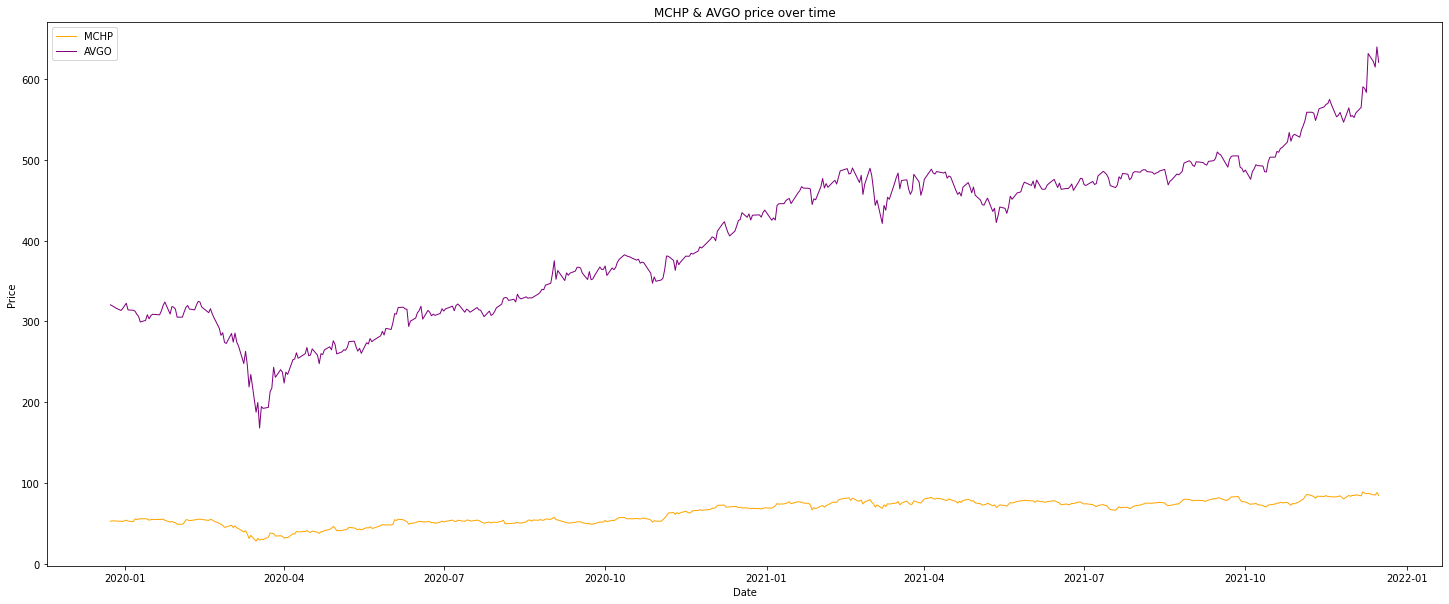

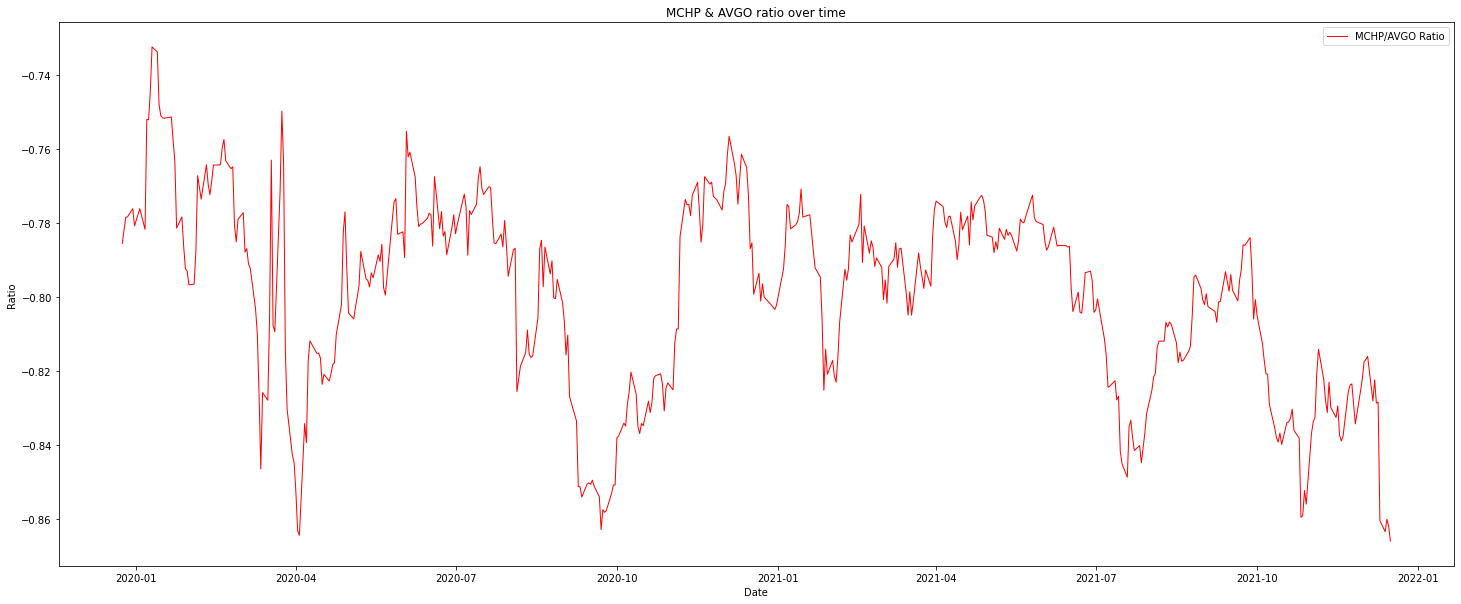

In [24]:
ticker1 = 'MCHP'
ticker2 = 'AVGO'

new_df = logAndRatio('XNGS', ticker1, ticker2)
corr, statio = pairCorr('XNGS', ticker1, ticker2)

print([ticker1, ticker2, corr, statio])
plotCharts(ticker1, ticker2, new_df)
plotRatio(ticker1, ticker2, new_df)

We can read for the MCHP/AVGO pair a correlation of 78% (at the time of the execution of this notebook the 18/12/2021) although one can observe a relatively flat curve next to another one which appears to be more volatile, this is explained by the fact that the calculation of the correlation is performed on the evolution of the price from one period to another and not on the price in itself. Indeed, an asset worth $1 at a time *t* and rising to $1.5 at *t+1* will have risen by 50% while taking only $0.50, whereas another asset worth $200 at *t* and then $300 at *t+1* will also have risen by 50% but will have increased by $100.

As for the stationarity, the *p*value of 8.9% does not invalidate the null hypothesis of non-stationarity. Nevertheless, we observe on the graph a shape that seems to have some fixed variance and mean over time despite small fluctuations that do not enable us to consider the series as stationary.

## ADI/TXN

['ADI', 'TXN', 0.8612341290670338, 0.09307750728651754]


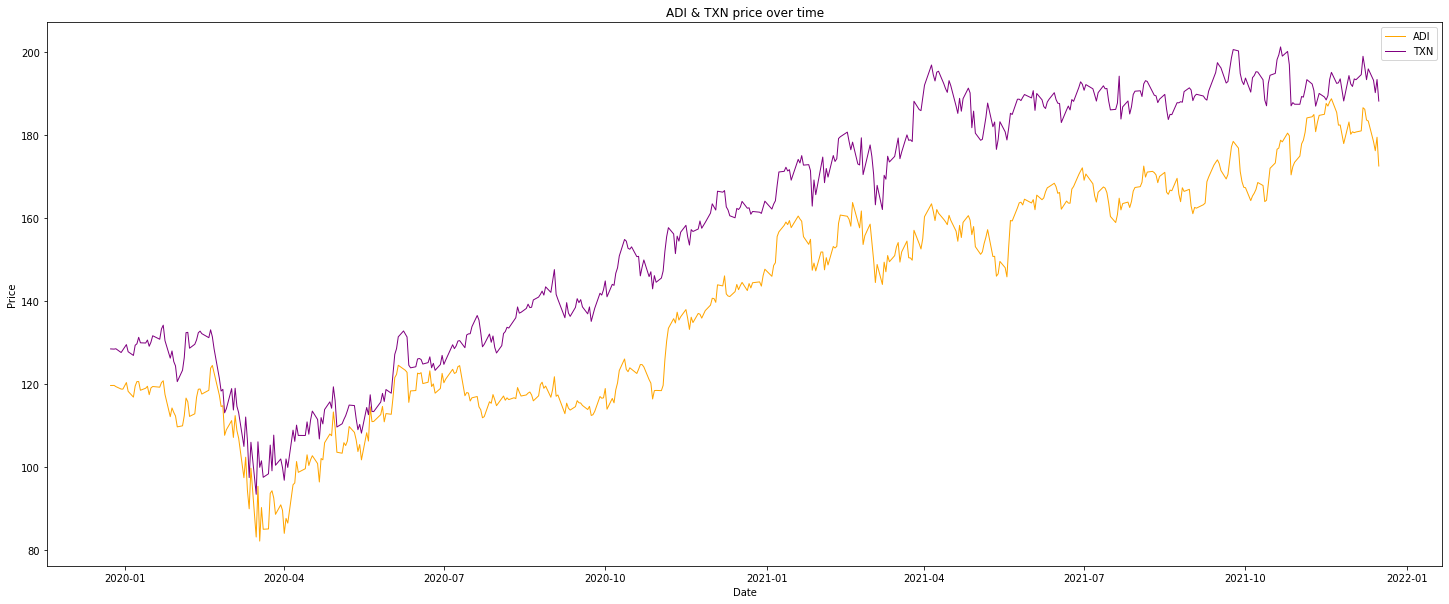

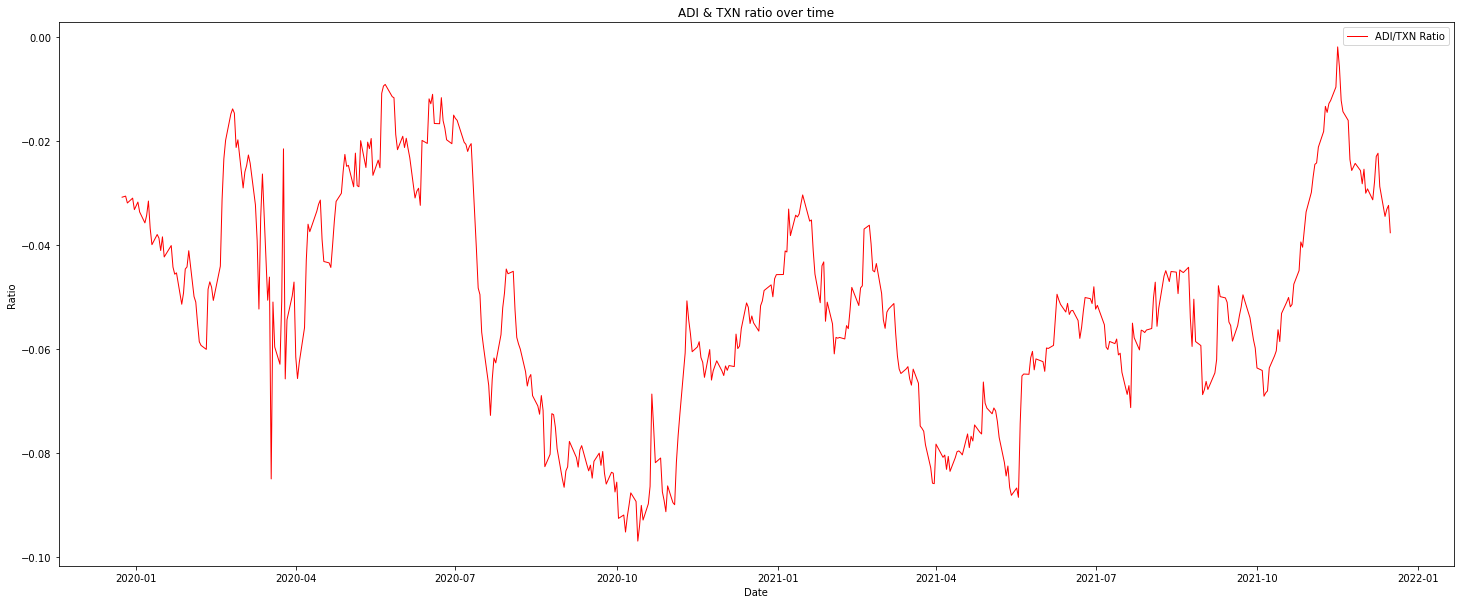

In [25]:
ticker1 = 'ADI'
ticker2 = 'TXN'

new_df = logAndRatio('XNGS', ticker1, ticker2)
corr, statio = pairCorr('XNGS', ticker1, ticker2)

print([ticker1, ticker2, corr, statio])
plotCharts(ticker1, ticker2, new_df)
plotRatio(ticker1, ticker2, new_df)

In this case the ADI/TXN pair is 86% correlated and this is easily confirmed by looking at the first chart where the lines are moving within the same price range and with the same main trend direction besides the pullbacks which appear to occur mostly at the same time.

Regarding stationarity, we get the same analysis as for the previous pair MCHP/AVGO.

## GOOG/GOOGL

['GOOG', 'GOOGL', 0.9920311751247849, 0.26165052446970405]


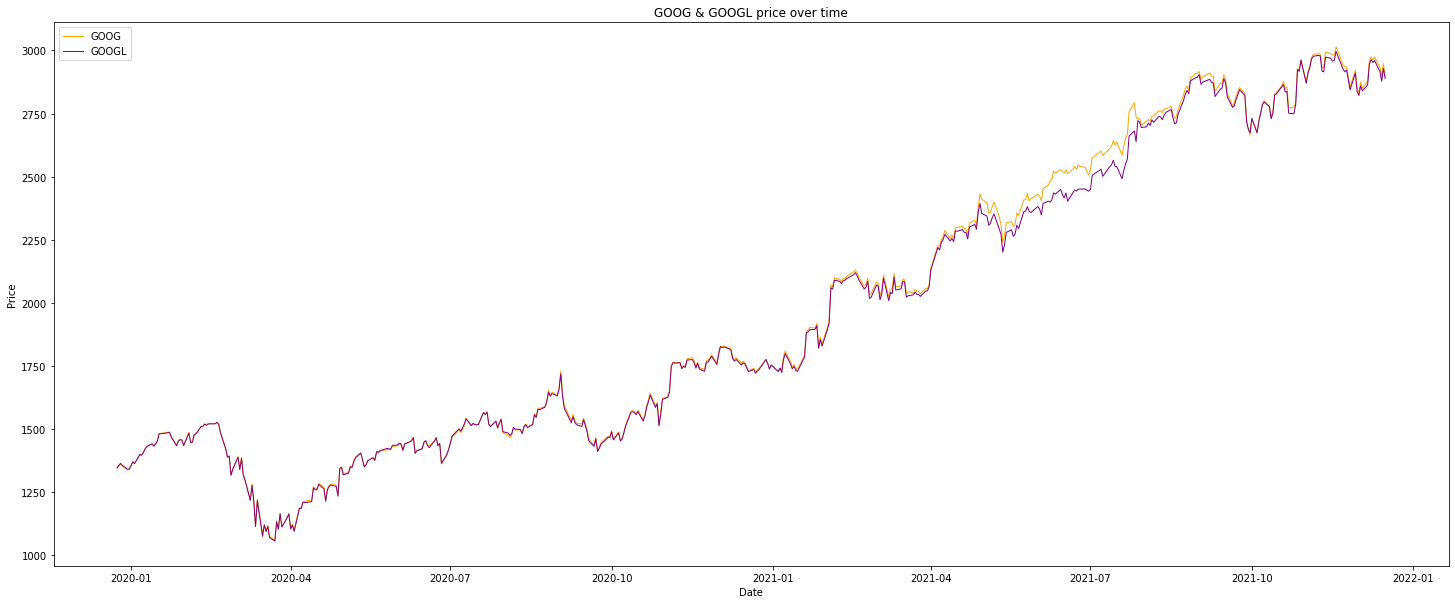

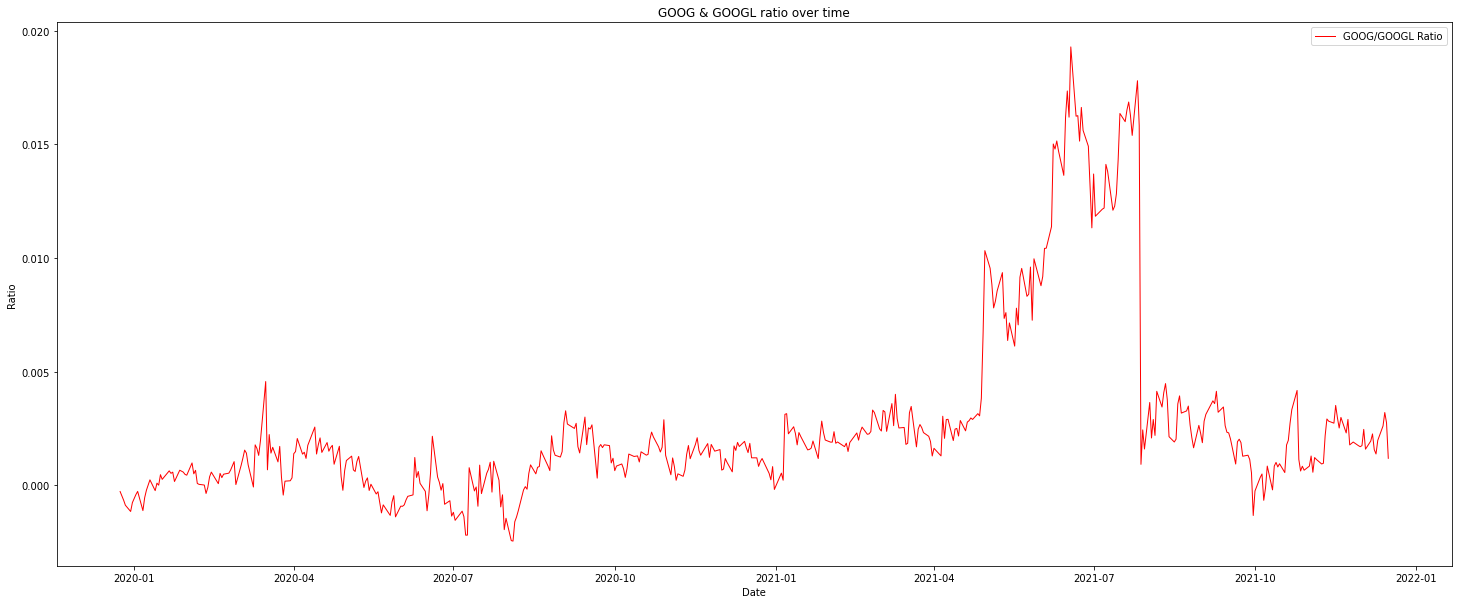

In [26]:
ticker1 = 'GOOG'
ticker2 = 'GOOGL'

new_df = logAndRatio('XNGS', ticker1, ticker2)
corr, statio = pairCorr('XNGS', ticker1, ticker2)

print([ticker1, ticker2, corr, statio])
plotCharts(ticker1, ticker2, new_df)
plotRatio(ticker1, ticker2, new_df)

Interesting, in order for Google's founders to keep control of the company they split their stocks shares in two: GOOGL shares of category A and GOOG shares of category C. The strategy behind this choice is that owners of GOOGL shares would have one vote per share, while owners of GOOG would have no voting rights. This is why GOOGL shares are generally a little more expensive than GOOG shares, although as we can see they are more than 99% correlated! We could therefore deduce that they are stationary between them but it is not so! Indeed these two stocks follow each other so much and their ratio must have a very stable variance and average over time, it only takes a small price shift for these variables to be affected and a "stronger" shift than usual (but in appearance not very violent) to completely disrupt the variance and mean over time.

## SGEN/MRNA

['SGEN', 'MRNA', 0.12501372602294153, 0.6084850603342085]


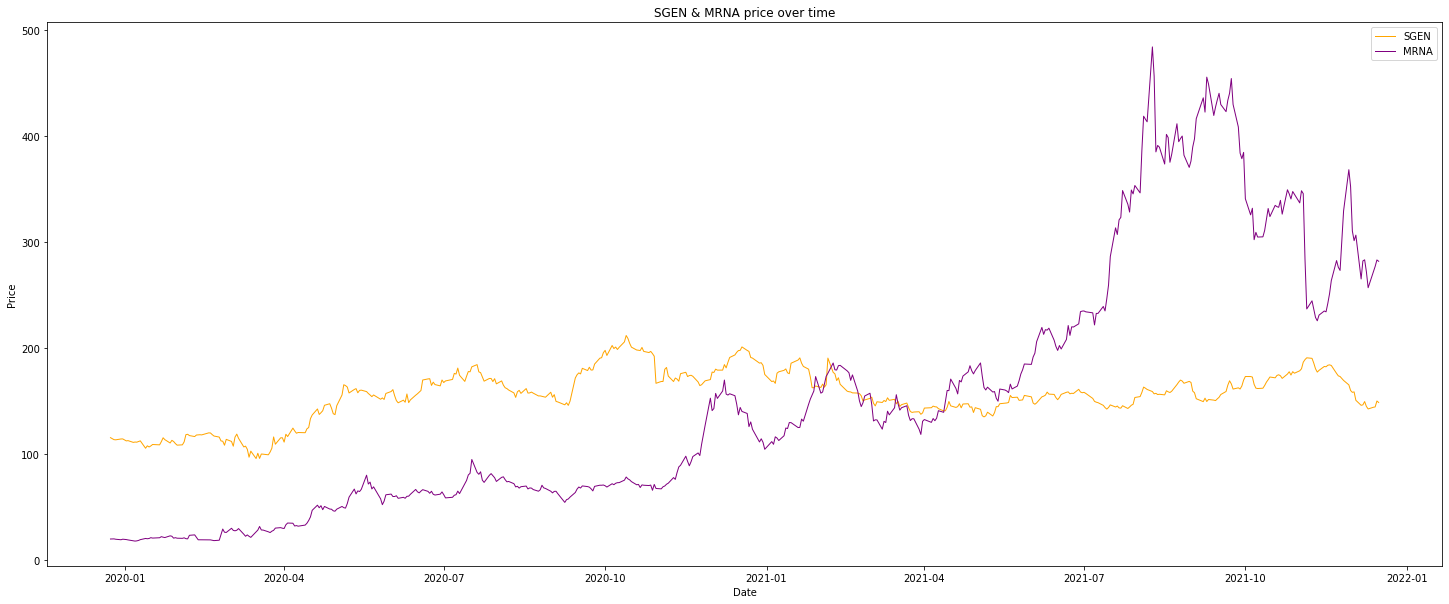

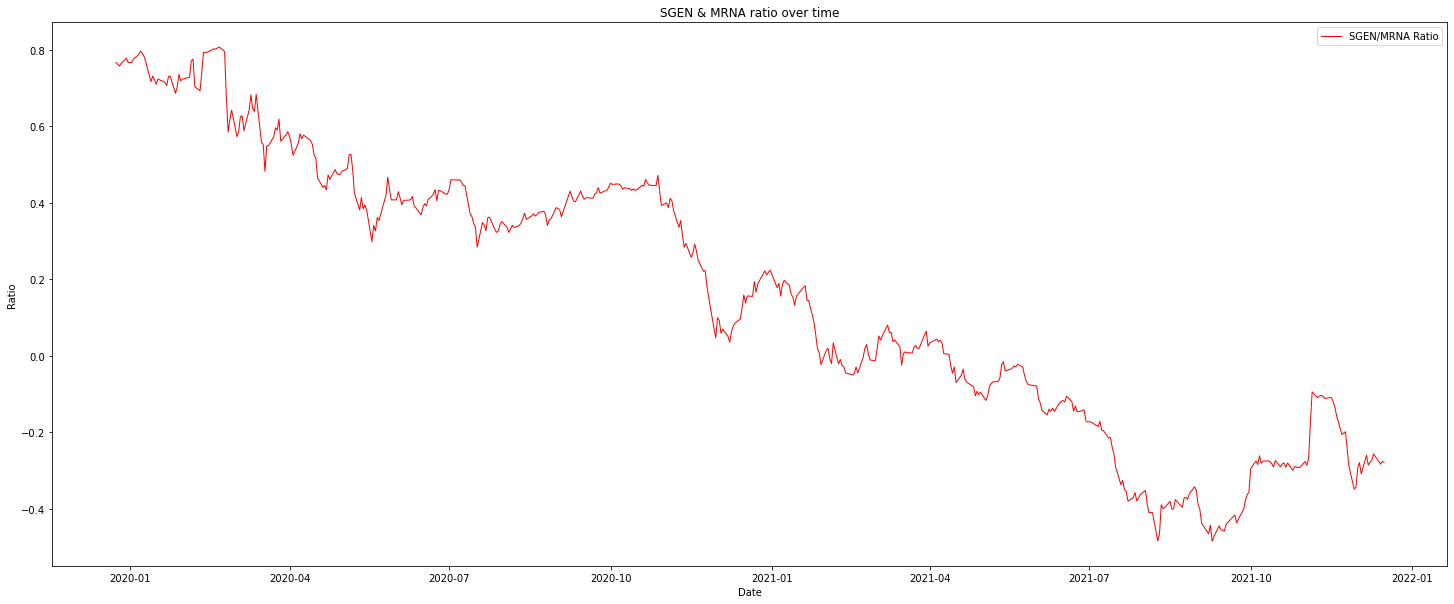

In [27]:
ticker1 = 'SGEN'
ticker2 = 'MRNA'

new_df = logAndRatio('XNGS', ticker1, ticker2)
corr, statio = pairCorr('XNGS', ticker1, ticker2)

print([ticker1, ticker2, corr, statio])
plotCharts(ticker1, ticker2, new_df)
plotRatio(ticker1, ticker2, new_df)

For this last example SGEN and MRNA are not correlated at all (only 12.5%) and it is very obvious that they are not stationary either: a declining trend implying a variance that is not stable at all and a mean that will continue to fall.

After this very quick study of testing a few combinations of assets within the same sector, we can assume that a correlated pair is not necessarily stationary although it may seem to be close, however, we have not conducted enough tests to make a general statement. Likewise, an uncorrelated pair does not seem to be stationary but is it true all the time ? Can't we find stationary but uncorrelated pairs ?

To find out possible answers to these questions we will investigate further.

# Correlation computation

For this next step we will go through all the sectors and retrieve the assets composing them in order to compare them two by two and give them a correlation and stationarity coefficient.

In [1]:
# print(unique_sectors)

In [29]:
corr_and_statio_list = []

for sect in unique_sectors:
    if ranked_total_sectors[ranked_total_sectors.Sector == sect].Total.tolist()[0] >= 2: # check if the sector contain at least two equity
        tickers_in_sector = data[data.Sector == sect].Ticker.tolist() # get all the tickers that belongs to that sector
        print(sect)
        print(tickers_in_sector)
        for ticker1, ticker2 in itertools.combinations(tickers_in_sector, 2): # compare all data in list in twos
            corr, statio = pairCorr('XNGS', ticker1, ticker2)
            corr_and_statio_list.append([ticker1, ticker2, corr, statio])
    
print()

corr_and_statio_list.sort(key=lambda x: abs(x[3])) # sort according the stationnarity (at index 3)
df_correlation = pd.DataFrame(corr_and_statio_list, columns=['Ticker 1', 'Ticker 2', 'Correlation', 'Stationnarity'])
df_correlation

Biotechnology: Biological Products (No Diagnostic Substances)
['SGEN', 'MRNA']
Other Consumer Services
['PTON', 'BKNG']
Television Services
['CHTR', 'CMCSA']
Medical Specialities
['DXCM', 'ILMN']
Catalog/Specialty Distribution
['MELI', 'EBAY', 'AMZN']
Auto Manufacturing
['PCAR', 'TSLA']
Broadcasting
['SIRI', 'FOX', 'FOXA']
Power Generation
['XEL', 'EXC']
Internet and Information Services
['FB', 'GOOGL', 'GOOG']
Department/Specialty Retail Stores
['COST', 'DLTR']
Industrial Machinery/Components
['AMAT', 'LRCX']
Biotechnology: Pharmaceutical Preparations
['VRTX', 'REGN', 'GILD', 'BIIB', 'AMGN']
Semiconductors
['MRVL', 'MCHP', 'NXPI', 'XLNX', 'SWKS', 'ADI', 'MU', 'AMD', 'AVGO', 'NVDA', 'TXN', 'INTC']
Computer Software: Prepackaged Software
['CHKP', 'TEAM', 'WDAY', 'SPLK', 'CDNS', 'ATVI', 'EA', 'ANSS', 'ADSK', 'INTU', 'ADBE', 'MSFT']
EDP Services
['OKTA', 'CRWD', 'DOCU', 'FISV', 'SNPS', 'VRSN', 'CTSH', 'CDW']
Computer peripheral equipment
['QCOM', 'CSCO']
Beverages (Production/Distribution

,Ticker 1,Ticker 2,Correlation,Stationnarity
0,CPRT,CTAS,0.668400,0.010620
1,GILD,BIIB,0.260270,0.011766
2,CPRT,PAYX,0.666346,0.015179
3,WDAY,ANSS,0.610255,0.018094
4,TEAM,INTU,0.498444,0.019665
...,...,...,...,...
201,MRVL,SWKS,0.696942,0.986803
202,CDNS,ATVI,0.547504,0.987965
203,SWKS,AVGO,0.808712,0.994593
204,ATVI,MSFT,0.541819,0.995327


We will display on a graph the resulting values in order to get a better understanding of them :

In [30]:
model = np.polyfit(df_correlation['Correlation'], df_correlation['Stationnarity'], 1)
predict = np.poly1d(model)
df_correlation['Linear Regression'] = predict(df_correlation['Correlation'])

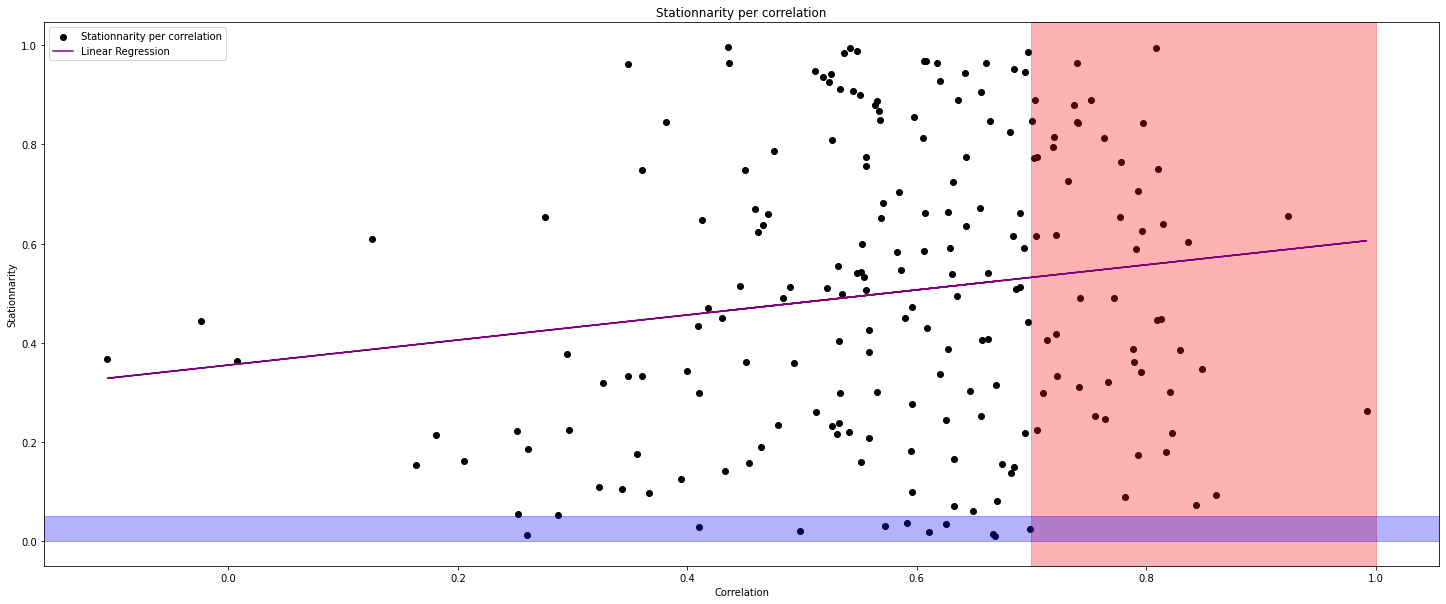

In [31]:
plt.figure(figsize=(25, 10))
plt.scatter(df_correlation['Correlation'], df_correlation['Stationnarity'], color="black", label="Stationnarity per correlation")
plt.plot(df_correlation['Correlation'], df_correlation['Linear Regression'], color="purple", label="Linear Regression")
plt.axvspan(mincorr_level, 1, color='red', alpha=0.3)
plt.axhspan(0, statio_level, color='blue', alpha=0.3)
plt.xlabel("Correlation")
plt.ylabel("Stationnarity")
plt.title("Stationnarity per correlation")
plt.legend()
plt.show()

The result is once again quite interesting, indeed, we do not distinguish a clear trend between the correlation (on the x-axis) and stationarity (y-axis) and although the linear regression seems to indicate a very slight relationship it is not yet sufficient to make a claim. *Moreover, when applying another method of stationarity calculation such as kpss or zivot-andrews the result is not so different.*

Concerning the distribution of the points, we notice that among the pairs that we considered as being sufficiently correlated at X% to be selected (red zone), none of them invalidate the null hypothesis of non-stationarity (blue zone for a *p*value < 5%). We can even observe that there are a fair number of pairs that are highly correlated but far from being stationary and conversely stationary but absolutely not correlated.

In [32]:
df_topcorrelation = df_correlation[df_correlation.Correlation > mincorr_level][df_correlation.Stationnarity < statio_level].reset_index(drop=True) if (use_adfuller or use_zivotandrews) else df_correlation[df_correlation.Correlation > mincorr_level][df_correlation.Stationnarity > statio_level].reset_index(drop=True)
df_topcorrelation

/tmp/ipykernel_458/516237156.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_topcorrelation = df_correlation[df_correlation.Correlation > mincorr_level][df_correlation.Stationnarity < statio_level].reset_index(drop=True) if (use_adfuller or use_zivotandrews) else df_correlation[df_correlation.Correlation > mincorr_level][df_correlation.Stationnarity > statio_level].reset_index(drop=True)


,Ticker 1,Ticker 2,Correlation,Stationnarity,Linear Regression


Not getting any result that meets our variables set at the beginning, we will adjust the correlation to 50% just to complete the simulation and save the supposedly valid selected data in a json file.

In [34]:
df_topcorrelation = df_correlation[df_correlation.Correlation > 0.5][df_correlation.Stationnarity < statio_level].reset_index(drop=True) if (use_adfuller or use_zivotandrews) else df_correlation[df_correlation.Correlation > mincorr_level][df_correlation.Stationnarity > statio_level].reset_index(drop=True)
df_topcorrelation

/tmp/ipykernel_458/967035761.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_topcorrelation = df_correlation[df_correlation.Correlation > 0.5][df_correlation.Stationnarity < statio_level].reset_index(drop=True) if (use_adfuller or use_zivotandrews) else df_correlation[df_correlation.Correlation > mincorr_level][df_correlation.Stationnarity > statio_level].reset_index(drop=True)


,Ticker 1,Ticker 2,Correlation,Stationnarity,Linear Regression
0,CPRT,CTAS,0.668400,0.010620,0.523980
1,CPRT,PAYX,0.666346,0.015179,0.523461
2,WDAY,ANSS,0.610255,0.018094,0.509284
3,XLNX,AMD,0.698744,0.024370,0.531649
4,MRVL,AMD,0.572748,0.031080,0.499805
5,WDAY,ADSK,0.625842,0.034157,0.513224
6,SNPS,CDW,0.591700,0.036589,0.504595


In [36]:
df_topcorrelation.to_json('records.json', orient = 'records')

Here is the format of the resulting json :

```json
[
    {"Ticker 1":"CPRT","Ticker 2":"CTAS","Correlation":0.6684001207,"Stationnarity":0.010620222,"Linear Regression":0.5239802538},
    {"Ticker 1":"CPRT","Ticker 2":"PAYX","Correlation":0.6663459713,"Stationnarity":0.0151790611,"Linear Regression":0.523461077},
    {"Ticker 1":"WDAY","Ticker 2":"ANSS","Correlation":0.6102550992,"Stationnarity":0.0180939327,"Linear Regression":0.5092843655},
    {"Ticker 1":"XLNX","Ticker 2":"AMD","Correlation":0.6987437769,"Stationnarity":0.0243699886,"Linear Regression":0.5316494742},
    {"Ticker 1":"MRVL","Ticker 2":"AMD","Correlation":0.5727479704,"Stationnarity":0.0310797982,"Linear Regression":0.4998046102},
    {"Ticker 1":"WDAY","Ticker 2":"ADSK","Correlation":0.6258423816,"Stationnarity":0.0341574382,"Linear Regression":0.5132239799},
    {"Ticker 1":"SNPS","Ticker 2":"CDW","Correlation":0.5917000704,"Stationnarity":0.0365893486,"Linear Regression":0.5045946668}
]
```